In [194]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots

In [195]:
import statsmodels.api as sm

In [196]:
from statsmodels.stats.outliers_influence \
     import variance_inflation_factor as VIF
from statsmodels.stats.anova import anova_lm

In [197]:
from ISLP import load_data, confusion_table
from ISLP.models import (ModelSpec as MS,
                         summarize,
                         poly)

사용하는 데이터는 library에 존재하는 데이터가 아니기 때문에 pandas library를 이용하기 위해서는 pandas library에서 데이터를 넣는 파일에 이 데이터 csv 파일을 추가로 저장해줘야 함

In [198]:
Data = load_data('Sleep_health_and_lifestyle_dataset')
Data.columns

Index(['Person ID', 'Gender', 'Age', 'Occupation', 'Sleep Duration',
       'Quality of Sleep', 'Physical Activity Level', 'Stress Level',
       'BMI Category', 'Blood Pressure', 'Heart Rate', 'Daily Steps',
       'Sleep Disorder'],
      dtype='object')

숫자형 자료만 사용하기 위해 데이터를 조작해야 함.

In [199]:
numeric_Data = Data.select_dtypes(include=[np.number])
numeric_Data.columns

Index(['Person ID', 'Age', 'Sleep Duration', 'Quality of Sleep',
       'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps'],
      dtype='object')

Person ID는 분석에 의미 없는 값이기 때문에 drop 한다.
Quality of Sleep은 target이므로 drop 한다.

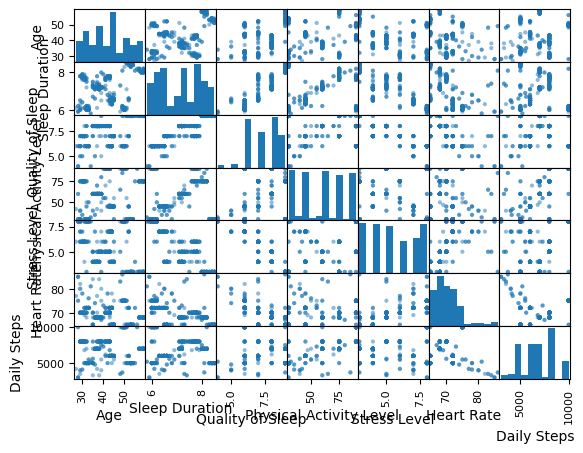

In [200]:
Nnumeric_Data = numeric_Data.drop(columns=['Person ID'])
pd.plotting.scatter_matrix(Nnumeric_Data);

In [201]:
Nnumeric_Data = Nnumeric_Data.drop(columns=['Quality of Sleep'])
X = MS(Nnumeric_Data).fit_transform(Data)
y = Data['Quality of Sleep']
model = sm.OLS(y, X)
result = model.fit()
summarize(result)

,coef,std err,t,P>|t|
intercept,5.28870,0.692000,7.646,0.000
Age,0.01410,0.002000,5.781,0.000
Sleep Duration,0.63880,0.043000,14.827,0.000
Physical Activity Level,-0.00070,0.002000,-0.335,0.738
Stress Level,-0.31570,0.025000,-12.633,0.000
Heart Rate,-0.02850,0.008000,-3.437,0.001
Daily Steps,0.00009,0.000026,3.477,0.001


ParseError가 발생할 경우 Presentation type을 KaTeX가 아닌 다른 방식으로 변경하면 해결할 수 있음

In [202]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Quality of Sleep   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     611.7
Date:                Thu, 23 May 2024   Prob (F-statistic):          1.14e-187
Time:                        21:21:09   Log-Likelihood:                -149.01
No. Observations:                 374   AIC:                             312.0
Df Residuals:                     367   BIC:                             339.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                   5.2887      0.692      7.646      0.000       3.929       6.649
Age                         0.0141      0.002      5.781      0.000       0.009       0.019
Sleep Duration              0.6388      0.043     14.827      0.000       0.554       0.724
Physical Activity Level    -0.0007      0.002     -0.335      0.738      -0.005       0.003
Stress Level               -0.3157      0.025    -12.633      0.000      -0.365      -0.267
Heart Rate                 -0.0285      0.008     -3.437      0.001      -0.045      -0.012
Daily Steps              8.968e-05   2.58e-05      3.477      0.001     3.9e-05       0.000
==============================================================================
Omnibus:                        2.414   Durbin-Watson:                   0.989
Prob(Omnibus):                  0.299   Jarque-Bera (JB):                2.151
Skew:                          -0.148   Prob(JB):                        0.341
Kurtosis:                       3.224   Cond. No.                     2.58e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Physical Activity Level에서만 t-value가 크게 발생하여 다른 방식으로 사용할 수 있는지 조사

In [203]:
X = MS([poly('Physical Activity Level', degree=2)]).fit_transform(Data)
model2 = sm.OLS(y, X)
result2 = model2.fit()
summarize(result2)

,coef,std err,t,P>|t|
intercept,7.3128,0.060,121.578,0.000
"poly(Physical Activity Level, degree=2)[0]",4.4592,1.163,3.833,0.000
"poly(Physical Activity Level, degree=2)[1]",-3.5370,1.163,-3.041,0.003


In [204]:
print(result2.rsquared)

0.06061858095418993


제곱을 했을 때 R-squared 값이 작아 믿을만 하지 않는 데이터가 발생함.
그래서 다른 parameter와 correlation 때문에 문제가 생기는지 궁금하여 correlation을 확인한다.

In [205]:
Nnumeric_Data.corr()

,Age,Sleep Duration,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
Age,1.000000,0.344709,0.178993,-0.422344,-0.225606,0.057973
Sleep Duration,0.344709,1.000000,0.212360,-0.811023,-0.516455,-0.039533
Physical Activity Level,0.178993,0.212360,1.000000,-0.034134,0.136971,0.772723
Stress Level,-0.422344,-0.811023,-0.034134,1.000000,0.670026,0.186829
Heart Rate,-0.225606,-0.516455,0.136971,0.670026,1.000000,-0.030309
Daily Steps,0.057973,-0.039533,0.772723,0.186829,-0.030309,1.000000


다른 parameter보다 Daily Steps이 관련이 많은 것 같아서 둘의 Interaction을 추가하여 model을 fitting 한다.

In [206]:
X = MS(['Age', 
        'Sleep Duration', 
        'Stress Level', 
        'Heart Rate', 
        ('Physical Activity Level', 'Daily Steps')]).fit_transform(Nnumeric_Data)
model3 = sm.OLS(y, X)
result3 = model3.fit()
summarize(result3)

,coef,std err,t,P>|t|
intercept,6.525900e+00,5.460000e-01,11.954,0.0
Age,1.380000e-02,3.000000e-03,5.482,0.0
Sleep Duration,6.235000e-01,4.300000e-02,14.470,0.0
Stress Level,-2.948000e-01,2.300000e-02,-12.700,0.0
Heart Rate,-4.080000e-02,6.000000e-03,-6.519,0.0
Physical Activity Level:Daily Steps,4.884000e-07,8.940000e-08,5.465,0.0


In [207]:
print(result3.rsquared)

0.9061901064013272


ParseError가 발생할 경우 Presentation type을 KaTeX가 아닌 다른 방식으로 변경하면 해결할 수 있음

In [208]:
result3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Quality of Sleep   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.905
Method:                 Least Squares   F-statistic:                     711.0
Date:                Thu, 23 May 2024   Prob (F-statistic):          1.28e-186
Time:                        21:21:09   Log-Likelihood:                -154.89
No. Observations:                 374   AIC:                             321.8
Df Residuals:                     368   BIC:                             345.3
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
intercept                               6.5259      0.546     11.954      0.000       5.452       7.599
Age                                     0.0138      0.003      5.482      0.000       0.009       0.019
Sleep Duration                          0.6235      0.043     14.470      0.000       0.539       0.708
Stress Level                           -0.2948      0.023    -12.700      0.000      -0.340      -0.249
Heart Rate                             -0.0408      0.006     -6.519      0.000      -0.053      -0.028
Physical Activity Level:Daily Steps  4.884e-07   8.94e-08      5.465      0.000    3.13e-07    6.64e-07
==============================================================================
Omnibus:                        2.818   Durbin-Watson:                   0.992
Prob(Omnibus):                  0.244   Jarque-Bera (JB):                2.545
Skew:                          -0.176   Prob(JB):                        0.280
Kurtosis:                       3.200   Cond. No.                     1.40e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.4e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [209]:
import sklearn.model_selection as skm

In [210]:
from sklearn.tree import (DecisionTreeRegressor as DTR,
                          plot_tree,
                          export_text)
from sklearn.ensemble import \
     (GradientBoostingRegressor as GBR)

In [211]:
model4 = MS(Nnumeric_Data, intercept=False)
D = model4.fit_transform(Data)
feature_names = list(D.columns)
X = np.asarray(D)

In [212]:
(X_train,
 X_test,
 y_train,
 y_test) = skm.train_test_split(X,
                                Data['Quality of Sleep'],
                                test_size=0.2,
                                random_state=0)

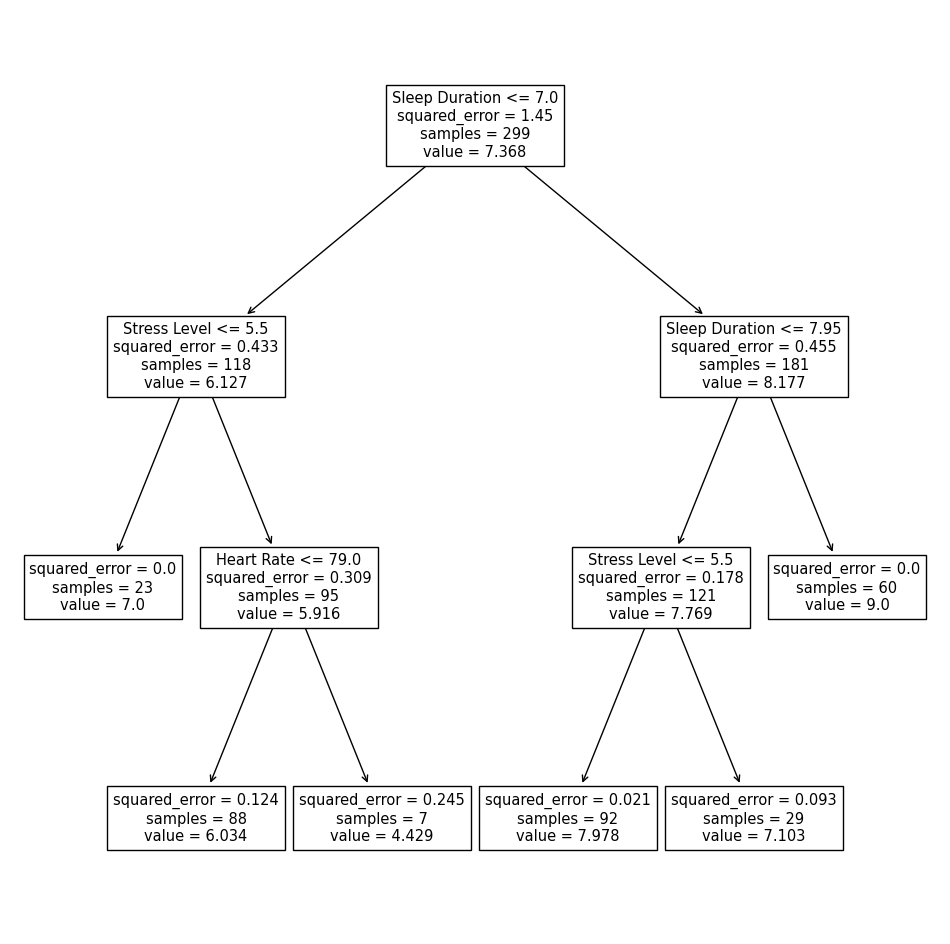

In [213]:
reg = DTR(max_depth=3)
reg.fit(X_train, y_train)
ax = subplots(figsize=(12,12))[1]
plot_tree(reg,
          feature_names=feature_names,
          ax=ax);

In [214]:
boost_data = GBR(n_estimators=5000,
                 learning_rate=0.001,
                 max_depth=3,
                 random_state=0)
boost_data.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.001, n_estimators=5000,
                          random_state=0)

In [215]:
y_hat_boost = boost_data.predict(X_test);
np.mean((y_test - y_hat_boost)**2)

0.036518055163689445

In [216]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [217]:
Nnumeric_Data['Physical Activity Level*Daily Steps'] = Nnumeric_Data['Physical Activity Level']*Nnumeric_Data['Daily Steps']
X = Nnumeric_Data.drop(columns=['Physical Activity Level'])
y = Data['Quality of Sleep']

In [218]:
lr_model = LinearRegression()
y_pred_cv_lr = cross_val_predict(lr_model, X, y, cv=10)
mse_cv_lr = mean_squared_error(y, y_pred_cv_lr)
print(mse_cv_lr)

0.22563617853428836


In [219]:
gb_model = GradientBoostingRegressor(
    n_estimators=5000,
    max_depth=3,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=0
)
y_pred_cv_gb = cross_val_predict(gb_model, X, y, cv=10)
r2_cv_gb = r2_score(y, y_pred_cv_gb)
print(r2_cv_gb)

0.9416959107133445
